In [386]:
import numpy as np
import pandas as pd
from scipy.stats import multinomial, norm, beta, bernoulli
from sklearn.model_selection import train_test_split

# Custom implementation

In this part, we apply our knowledge of the naive Bayes classifier to create it from scratch. We will test a Bernoulli model and a Gaussian model, and compare these analytical approaches with the probabilistic approach taken in the stan notebook.

## Class definition

First we define the classifier class. It takes the same shape as the sklearn classifiers, so understanding it is not vital.

In [387]:
class NaiveBayes:
  def __init__(self, param_priors=None):
    # hyperparameters of the parameter priors used by the prob_func in case a
    # Bayesian approach is taken
    self.param_priors = param_priors
  
  def compute_params(self, X):
    # to be defined in a subclass
    # function to compute the distribution parameters
    # the function should return an list of parameter arrays (...)
    pass

  def compute_probabilities(self, X, params):
    # to be defined in a subclass
    # user-provided function to compute the probabilities from the parameters
    # the input are the parameter arrays and the X
    pass

  def fit(self, X, y):
    # retrieve the number of samples and features from X
    self.n_samples, self.n_features = X.shape

    # collect the individual classes, and record their counts to compute priors
    self.classes, counts = np.unique(y, return_counts=True)

    # compute the parameters for every class - we transpose the array so that
    # the final dimensions are (parameters, classes, features)
    self.params = np.array(
      [self.compute_params(X[c==y]) for c in self.classes]
    ).transpose(1, 0, 2)

    # compute the priors from the counts
    self.class_probs = np.log(counts/self.n_samples)

    return self

  def posteriors(self, X):
    # reshape X to fit the array dimensions (samples, classes, features)
    X = np.reshape(X, (-1, 1, self.n_features))

    # compute the probabilities of the samples (...)
    probs = self.compute_probabilities(X, *self.params[:,np.newaxis])
    return probs.sum(axis=2) + self.class_probs[np.newaxis]

  def predict_proba(self, X):
    # predict the probabilities for each class
    exp_post = np.exp(self.posteriors(X))
    return exp_post / exp_post.sum()

  def predict(self, X):
    # predict the class with the maximum probability
    return self.classes[np.argmax(self.posteriors(X), axis=1)]

## Bernoulli model: toy dataset

In order to test the Bernoulli model, we define a toy dataset. The reason is that only the Stan models quickly take too much time for larger datasets, and small real datasets are hard to comeby. Moreover, this dataset is fine for our purpose, which is mostly testing our analytical and Stan implementations.

In [413]:
class BernoulliNB(NaiveBayes):
  def compute_params(self, X):
    return [X.mean(axis=0)]
  
  def compute_probabilities(self, X, phi):
    return bernoulli.logpmf(X, phi)

In [414]:
# define dataset
X = np.array([[0, 0, 1, 1, 1],
              [1, 0, 1, 1, 0],
              [1, 1, 0, 0, 1],
              [1, 1, 0, 0, 0],
              [0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0],
              [1, 0, 0, 1, 1],
              [1, 1, 0, 0, 1],
              [1, 1, 1, 1, 0],
              [1, 1, 0, 1, 0],
              [1, 1, 0, 1, 1],
              [1, 0, 1, 1, 0],
              [1, 0, 1, 0, 0]])
y = 6*[0] + 7*[1]

# initialize the class with to the proper functions and fit to the data
nb = BernoulliNB().fit(X, y)

# we evaluate a random sample to compare with the Stan notebook
nb.predict_proba([1,0,1,1,0])

array([[0.19237241, 0.80762759]])

### Bayesian version

Now we take a Bayesian approach of the same function. Only the parameter function needs to be changed to instead return a MAP incorporating the prior defined by the hyperparameters

In [439]:
class BayesBernoulliNB(BernoulliNB):
  def compute_params(self, X):
    a, b = self.param_priors
    return [beta.mean(a + X.sum(axis=0), b + len(X) - X.sum(axis=0))]
    # alpha = self.param_priors
    # return [
    #   (X.sum(axis=0) + alpha[1] - 1) / (len(X) + alpha.sum(axis=0) - 2)
    # ]

We instantiate a new classifier with the specified functions and evaluate it

In [442]:
nb = BayesBernoulliNB(
  param_priors=np.full((2, 5), 1)
).fit(X, y)

nb.predict_proba([1,0,1,1,0])

array([[0.23601128, 0.76398872]])

In [432]:
nb.params

array([[[0.5       , 0.5       , 0.33333333, 0.5       , 0.5       ],
        [1.        , 0.57142857, 0.42857143, 0.71428571, 0.42857143]]])

In [108]:
nb = BayesBernoulliNB(
  param_priors=np.full((2, 5), 2)
).fit(X, y)

nb.predict_proba([1,0,1,1,0])

array([[0.23601128, 0.76398872]])

As we might have expected, the probabilities tend more towards the center as the parameters are smoothed by their priors

## Gaussian model: Raisin dataset

Finally, we evaluate the Gaussian model using the raisin dataset

In [109]:
df = pd.read_csv('data/Raisin_Dataset.csv')
x = np.array(df.drop("Class", axis=1))
y = np.array(df["Class"])
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)

Define the parameter function returning the means and variances of the classes in the dataset and a gaussian function to calculate the probability densities of the according distributions

In [116]:
class GaussianNB(NaiveBayes):
  def compute_params(self, X):
    return [X.mean(axis=0), X.var(axis=0)]

  def compute_probabilities(self, X, mean, var):
    return norm.logpdf(X, mean, np.sqrt(var))

We center and scale the data to zero mean and unit variance according to the test set. This is to take the same approach as in the Stan notebook, where it is done to be able to use center normal priors.

In [117]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

nb = GaussianNB().fit(xtrain, ytrain)
y_pred = nb.predict(xtest)
(y_pred == ytest).mean()

0.8388888888888889

We find similar accuracy to the sklearn model

## Multinomial model

### Dataset

In [452]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/otis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [504]:
url = "https://raw.githubusercontent.com/suraj-deshmukh/BBC-Dataset-News-Classification/master/dataset/dataset.csv"
df = pd.read_csv(url, encoding="unicode_escape", dtype={'type': 'category'})

In [505]:
df = df.rename(columns={'type': '.type'})
classes = df['.type'].cat.categories
classes

Index(['business', 'entertainment', 'politics', 'sport', 'tech'], dtype='object')

In [506]:
df_train, df_test = np.split(df.sample(n=1000), [100])

In [507]:
for df in [df_train, df_test]:
  df['news'] = df['news'].str.lower()\
    .map(RegexpTokenizer(r"\w+").tokenize)
  df['.type'] = df['.type'].cat.codes

df_train.head()

,news,.type
1172,"[campaign, cold, calls, questioned, labour, an...",2
629,"[paraguay, novel, wins, us, book, prize, a, no...",1
968,"[kennedy, s, cautious, optimism, charles, kenn...",2
317,"[algeria, hit, by, further, gas, riots, algeri...",0
1486,"[smith, keen, on, home, series, return, scotla...",3


In [508]:
corpus = df_train['news'].map(lambda l: [el for el in l if el not in stopwords]).sum()
all_words, counts = np.unique(corpus, return_counts=True)
words = all_words[np.argsort(-counts)][:200]

for df in [df_train, df_test]:
  articles = df['news']
  df.drop(columns='news', inplace=True)
  df[words] = pd.DataFrame(
    articles.map(lambda article: [article.count(word) for word in words]).tolist(),
    df.index
  )

df_train.head()

/var/folders/bv/ghbrqbgj6g9crhy3384p3ggw0000gn/T/ipykernel_12862/4207672381.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[words] = pd.DataFrame(
/var/folders/bv/ghbrqbgj6g9crhy3384p3ggw0000gn/T/ipykernel_12862/4207672381.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[words] = pd.DataFrame(
/var/folders/bv/ghbrqbgj6g9crhy3384p3ggw0000gn/T/ipykernel_12862/4207672381.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

,.type,said,mr,people,year,would,also,new,us,one,...,side,month,smith,third,spending,economic,start,got,sure,online
1172,2,9,1,8,0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
629,1,2,0,1,4,1,0,3,4,1,...,0,0,0,0,0,0,0,0,0,0
968,2,3,2,2,1,1,3,1,2,4,...,1,0,0,2,1,0,0,0,0,0
317,0,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1486,3,1,0,0,0,4,0,1,0,1,...,0,0,4,0,0,0,0,0,0,0


In [509]:
# df_train.to_csv('data/articles_train.csv', index=False)
# df_test.to_csv('data/articles_test.csv', index=False)
X_train = df_train.drop(columns=['.type']).values
y_train = df_train['.type'].values
X_test = df_test.drop(columns=['.type']).values
y_test = df_test['.type'].values

### Classifier

In [510]:
class MultinomialNB(NaiveBayes):
  def __init__(self, alpha=0):
    self.alpha = alpha

  def compute_params(self, X):
    counts = X.sum(axis=0) + self.alpha
    return [counts/counts.sum()]

  def compute_probabilities(self, X, params):
    return multinomial.logpmf(X, X.sum(axis=2), params)[...,np.newaxis]

In [511]:
clf = MultinomialNB(alpha=1).fit(X_train, y_train)
print(np.mean(y_train == clf.predict(X_train)))
print(np.mean(y_test == clf.predict(X_test)))

1.0
0.8644444444444445


In [481]:
idx = X_train.nonzero()
values = X_train[idx]
word_ids = np.repeat(idx[1],values)
doc_ids = np.repeat(idx[0],values)

In [482]:
with open('model_multinomial.stan') as f:
  stan_model = f.read()
print(stan_model)

// code adapted from stan user's guide
// https://mc-stan.org/docs/2_29/stan-users-guide/naive-bayes-classification-and-clustering.html

data {
  // training data
  int<lower=1> K;               // num topics
  int<lower=1> V;               // num words
  int<lower=0> M;               // num docs
  int<lower=0> N;               // total word instances
  int<lower=1, upper=K> z[M];   // topic for doc m
  int<lower=1, upper=V> w[N];   // word n
  int<lower=1, upper=M> doc[N]; // doc ID for word n
  // hyperparameters
  vector<lower=0>[K] alpha;     // topic prior
  vector<lower=0>[V] beta;      // word prior
}
parameters {
  simplex[K] theta;             // topic prevalence
  simplex[V] phi[K];            // word dist for topic k
}
model {
  // priors
  theta ~ dirichlet(alpha);
  for (k in 1:K) {
    phi[k] ~ dirichlet(beta);
  }

  // data
  for (m in 1:M) {
    z[m] ~ categorical(theta);
  }
  for (n in 1:N) {
    w[n] ~ categorical(phi[z[doc[n]]]);
  }
}



In [488]:
data = {
  'K': max(y_train) + 1,                 # num topics
  'V': X_train.shape[1],                 # num words
  'M': X_train.shape[0],                 # num docs
  'N': len(word_ids),                    # total word instances
  'z': y_train + 1,                      # topic for doc m
  'w': word_ids + 1,                     # word n
  'doc': doc_ids + 1,                    # doc ID for word n
  'alpha': np.full(max(y_train) + 1, 1), # topic prior
  'beta': np.full(X_train.shape[1], 1)   # word prior
}

In [489]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio
import stan

posterior = stan.build(stan_model, data=data)
fit = posterior.sample(num_chains=4, num_samples=1000)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/bv/ghbrqbgj6g9crhy3384p3ggw0000gn/T/httpstan_ll1y6hjc/model_dvhd6v2f.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/bv/ghbrqbgj6g9crhy3384p3ggw0000gn/T/httpstan_ll1y6hjc/model_dvhd6v2f.stan', line 11, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/bv/ghbrqbgj6g9crhy3384p3ggw0000gn/T/httpstan_ll1y6hjc/model_dvhd6v2f.stan', line 12, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    wil

In [381]:
clf = MultinomialNB().fit(X_train, y_train)
clf.class_probs = fit['theta'].mean(axis=-1)
clf.params = fit['phi'].mean(axis=-1)[np.newaxis]
print(np.mean(y_train == clf.predict(X_train)))
print(np.mean(y_test == clf.predict(X_test)))

0.93
0.87


In [382]:
df_train[df_train.iloc[:,99] > 0]

,type,said,mr,year,would,also,us,one,new,people,...,internet,side,going,blair,france,expected,end,third,election,2004
1171,2,4,8,1,5,2,0,1,0,3,...,0,0,4,1,0,1,0,0,4,0
1262,2,4,6,1,2,1,1,0,0,5,...,0,0,0,2,0,1,0,0,7,0
1191,2,3,5,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1226,2,3,6,1,1,1,0,1,0,0,...,0,0,2,8,0,2,1,2,5,0
1024,2,1,1,0,4,0,0,2,0,1,...,0,0,0,3,0,0,0,0,4,0
907,2,10,0,0,4,0,0,3,1,2,...,0,0,3,0,0,1,1,0,1,0


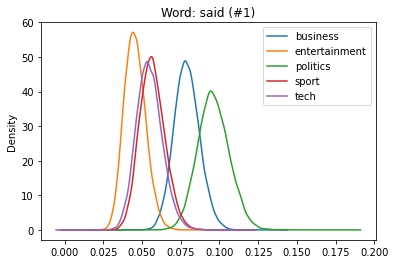

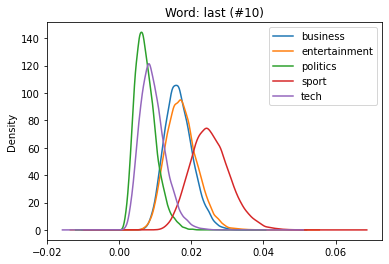

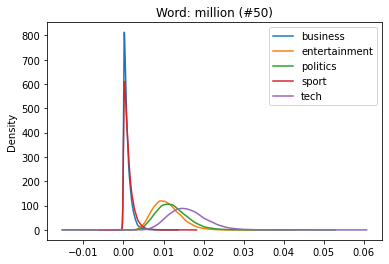

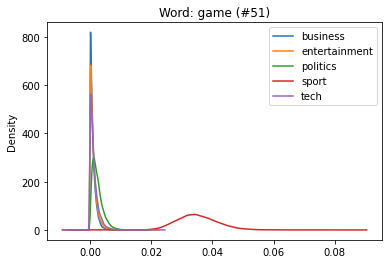

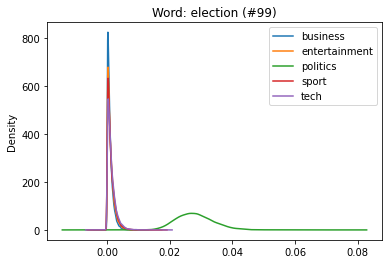

In [383]:
df = fit.to_frame()
for i in [1,10,50,51,99]:
  ax = df[[f'phi.{c}.{i}' for c in range(1,6)]].plot(
    kind='density',
    title=f'Word: {df_train.columns[i]} (#{i})')
  ax.legend(classes)

In [298]:
df.rename(columns={classes[c]: f'phi.{c+1}.{1}' for c in range(5)})

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1,theta.2,theta.3,...,phi.1.99,phi.2.99,phi.3.99,phi.4.99,phi.5.99,phi.1.100,phi.2.100,phi.3.100,phi.4.100,phi.5.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-21206.616131,0.777783,0.234432,4.0,15.0,0.0,21450.854235,0.177443,0.088869,0.224901,...,0.002041,0.001771,0.003743,0.011863,0.003740,0.000598,0.003161,0.000422,0.024432,0.002557
1,-21184.167179,0.753411,0.225316,4.0,15.0,0.0,21407.615316,0.233363,0.170098,0.160056,...,0.002738,0.000606,0.001723,0.015451,0.004765,0.002004,0.006542,0.001325,0.021098,0.001451
2,-21183.733489,0.746351,0.239674,4.0,15.0,0.0,21460.681874,0.178487,0.137492,0.245618,...,0.004179,0.001763,0.003343,0.010735,0.007667,0.001075,0.002269,0.002187,0.019963,0.001432
3,-21180.882101,0.966348,0.199018,5.0,31.0,0.0,21424.039853,0.174007,0.081935,0.222392,...,0.002229,0.000158,0.001310,0.012549,0.003855,0.002205,0.003501,0.002581,0.020319,0.002172
4,-21187.441913,0.914548,0.234432,4.0,15.0,0.0,21448.546210,0.184316,0.118424,0.225950,...,0.005973,0.000194,0.001610,0.014947,0.005255,0.002299,0.001915,0.002060,0.020795,0.001173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-21169.073209,0.943320,0.199018,5.0,31.0,0.0,21396.790181,0.210985,0.164202,0.180592,...,0.001993,0.000368,0.003508,0.019471,0.004553,0.000997,0.002796,0.000541,0.023999,0.001036
3996,-21186.657977,0.843779,0.234432,4.0,15.0,0.0,21435.598646,0.225785,0.223836,0.172909,...,0.002897,0.000931,0.003729,0.014881,0.005666,0.000838,0.008166,0.002531,0.020709,0.003783
3997,-21203.167863,0.630159,0.225316,4.0,15.0,0.0,21473.591561,0.200127,0.134100,0.176476,...,0.001814,0.002826,0.004447,0.015252,0.002202,0.000145,0.003105,0.000762,0.029215,0.001054


In [299]:
fit.to_frame()['phi.2.6','phi.5.6']

KeyError: ('phi.2.6', 'phi.5.6')